import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

In [1]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import Sequence


c:\Users\Javier\miniconda3\envs\computervision\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

# Keras data generator class
class ImageDataGenerator(Sequence):
    def __init__(self, color_path, gray_path, batch_size, img_size, limit=6000, **kwargs):
        super().__init__(**kwargs)  # Ensure compatibility with Keras by calling the superclass initializer
        self.color_path = color_path
        self.gray_path = gray_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.limit = limit

        # Load and sort files
        self.color_files = sorted_alphanumeric(os.listdir(color_path))[:limit]
        self.gray_files = sorted_alphanumeric(os.listdir(gray_path))[:limit]
        self.indexes = np.arange(len(self.color_files))

        # Optimize data pipeline with TensorFlow Dataset API
        self.dataset = self._create_tf_dataset()

    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.color_files) / self.batch_size))

    def _load_image(self, color_file, gray_file):
        color_file = color_file.numpy().decode('utf-8')
        gray_file = gray_file.numpy().decode('utf-8')

        #Read and transform color and gray img properly
        color_img = cv2.imread(os.path.join(self.color_path, color_file), 1)
        color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
        color_img = cv2.resize(color_img, (self.img_size, self.img_size))
        color_img = color_img.astype('float32') / 255.0

        gray_img = cv2.imread(os.path.join(self.gray_path, gray_file), 1)
        gray_img = cv2.resize(gray_img, (self.img_size, self.img_size))
        gray_img = gray_img.astype('float32') / 255.0

        return tf.convert_to_tensor(gray_img, dtype=tf.float32), tf.convert_to_tensor(color_img, dtype=tf.float32)

    def _create_tf_dataset(self):
        # Create a TensorFlow dataset from the file paths
        dataset = tf.data.Dataset.from_tensor_slices((self.color_files, self.gray_files))

        # Map the _load_image function to the dataset
        dataset = dataset.map(
            lambda color_file, gray_file: tf.py_function(
                self._load_image,
                [color_file, gray_file],
                [tf.float32, tf.float32]
            ),
            num_parallel_calls=tf.data.AUTOTUNE
        )

        # Batch, prefetch, and shuffle the dataset
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

        return dataset


    def __getitem__(self, index):
        # Fetch the batch using TensorFlow Dataset API
        batch = next(iter(self.dataset.skip(index).take(1)))
        return batch

    def on_epoch_end(self):
        # Recreate the dataset to ensure new ordering
        self.dataset = self._create_tf_dataset()




In [4]:
def downsample(filters, size, apply_batchnorm=True):

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer='he_normal', use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):


  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.2))

  result.add(tf.keras.layers.ReLU())

  return result

In [5]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[160, 160, 3])

    down_stack = [
        downsample(128, 4, apply_batchnorm=False), # (bs, 64, 64, 64)
        downsample(128, 4), # (bs, 32, 32, 128)
        downsample(256, 4), # (bs, 16, 16, 256)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 512)
        upsample(256, 4), # (bs, 32, 32, 256)
        upsample(128, 4), # (bs, 64, 64, 128)
        upsample(128, 4), # (bs, 128, 128, 64)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [6]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[160, 160, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[160, 160, 3], name='target_image')

  x = tf.keras.layers.Concatenate()([inp, tar])  # (bs, 128, 128, channels*2)

  down1 = downsample(64, 4, False)(x)  # (bs, 64, 64, 64)
  down2 = downsample(128, 4)(down1)    # (bs, 32, 32, 128)
  down3 = downsample(256, 4)(down2)    # (bs, 16, 16, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 17, 17, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 14, 14, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 15, 15, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 12, 12, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [11]:
generator = Generator()
generator.summary()
#generator.load_weights('generator.weights.h5')
#generator.save('generator.keras')

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_24       │ (None, 80, 80,    │      6,144 │ input_layer_26[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_25       │ (None, 40, 40,    │    262,656 │ sequential_24[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_26       │ (None, 20, 20,    │    525,312 │ sequential_25[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_27       │ (None, 10, 10,    │  2,099,200 │ sequential_26[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_28       │ (None, 5, 5, 512) │  4,196,352 │ sequential_27[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_29       │ (None, 10, 10,    │  4,196,352 │ sequential_28[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 10, 10,    │          0 │ sequential_29[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_27[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_30       │ (None, 20, 20,    │  4,195,328 │ concatenate_10[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 20, 20,    │          0 │ sequential_30[0]… │
│ (Concatenate)       │ 512)              │            │ sequential_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_31       │ (None, 40, 40,    │  1,049,088 │ concatenate_11[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 40, 40,    │          0 │ sequential_31[0]… │
│ (Concatenate)       │ 256)              │            │ sequential_25[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_32       │ (None, 80, 80,    │    524,800 │ concatenate_12[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 80, 80,    │          0 │ sequential_32[0]… │
│ (Concatenate)       │ 256)              │            │ sequential_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_14 │ (None, 160, 160,  │     12,291 │ concatenate_13[0… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,067,523 (65.11 MB)

 Trainable params: 17,062,659 (65.09 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [10]:
discriminator = Discriminator()
discriminator.summary()
#discriminator.load_weights('discriminator.weights.h5')
#discriminator.save('discriminator.keras')

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 160, 160,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_21       │ (None, 80, 80,    │      6,144 │ concatenate_9[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_22       │ (None, 40, 40,    │    131,584 │ sequential_21[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_23       │ (None, 20, 20,    │    525,312 │ sequential_22[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 22, 22,    │          0 │ sequential_23[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 19, 19,    │  2,097,152 │ zero_padding2d_2… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │      2,048 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 19, 19,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 21, 21,    │          0 │ leaky_re_lu_17[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 18, 18, 1) │      8,193 │ zero_padding2d_3… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [8]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)

#Check MSE Loss

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    # Ensure all tensors are of type float32
  target = tf.cast(target, tf.float32)
  gen_output = tf.cast(gen_output, tf.float32)
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss



def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [9]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))



In [10]:
import time
# Function to fit the model
def fit(train_ds, epochs):
    for epoch in range(epochs):
        start = time.time()

        print("Epoch: ", epoch + 1)

        # Train
        for batch in train_ds:
            input_image, target = batch
            train_step(input_image, target, epoch)

        print()
        print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time() - start))

In [11]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()
"""
for example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(2):
  generate_images(generator, example_input, example_target)
"""

'\nfor example_input, example_target in tf.data.Dataset.zip((gray_dataset,color_dataset)).take(2):\n  generate_images(generator, example_input, example_target)\n'

In [12]:
# Paths to your datasets
color_path = '../input/landscape-image-colorization/landscape Images/color'
gray_path = '../input/landscape-image-colorization/landscape Images/gray'
img_size = 160
batch_size = 64
epochs = 20

# Create an instance of the ImageDataGenerator
train_ds = ImageDataGenerator(color_path=color_path, gray_path=gray_path, batch_size=batch_size, img_size=img_size,limit = 1500)

# Call the fit function with the data generator
fit(train_ds, epochs)

Epoch:  1

Time taken for epoch 1 is 886.1789309978485 sec

Epoch:  2

Time taken for epoch 2 is 866.7375974655151 sec

Epoch:  3

Time taken for epoch 3 is 887.405588388443 sec

Epoch:  4

Time taken for epoch 4 is 892.5280547142029 sec

Epoch:  5

Time taken for epoch 5 is 904.1775715351105 sec

Epoch:  6

Time taken for epoch 6 is 907.8393800258636 sec

Epoch:  7

Time taken for epoch 7 is 909.878246307373 sec

Epoch:  8

Time taken for epoch 8 is 898.530086517334 sec

Epoch:  9

Time taken for epoch 9 is 901.7555983066559 sec

Epoch:  10

Time taken for epoch 10 is 921.3494465351105 sec

Epoch:  11

Time taken for epoch 11 is 894.0476174354553 sec

Epoch:  12

Time taken for epoch 12 is 898.0443062782288 sec

Epoch:  13

Time taken for epoch 13 is 898.5059251785278 sec

Epoch:  14

Time taken for epoch 14 is 902.3347768783569 sec

Epoch:  15

Time taken for epoch 15 is 904.048805475235 sec

Epoch:  16

Time taken for epoch 16 is 896.1371304988861 sec

Epoch:  17

Time taken for epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


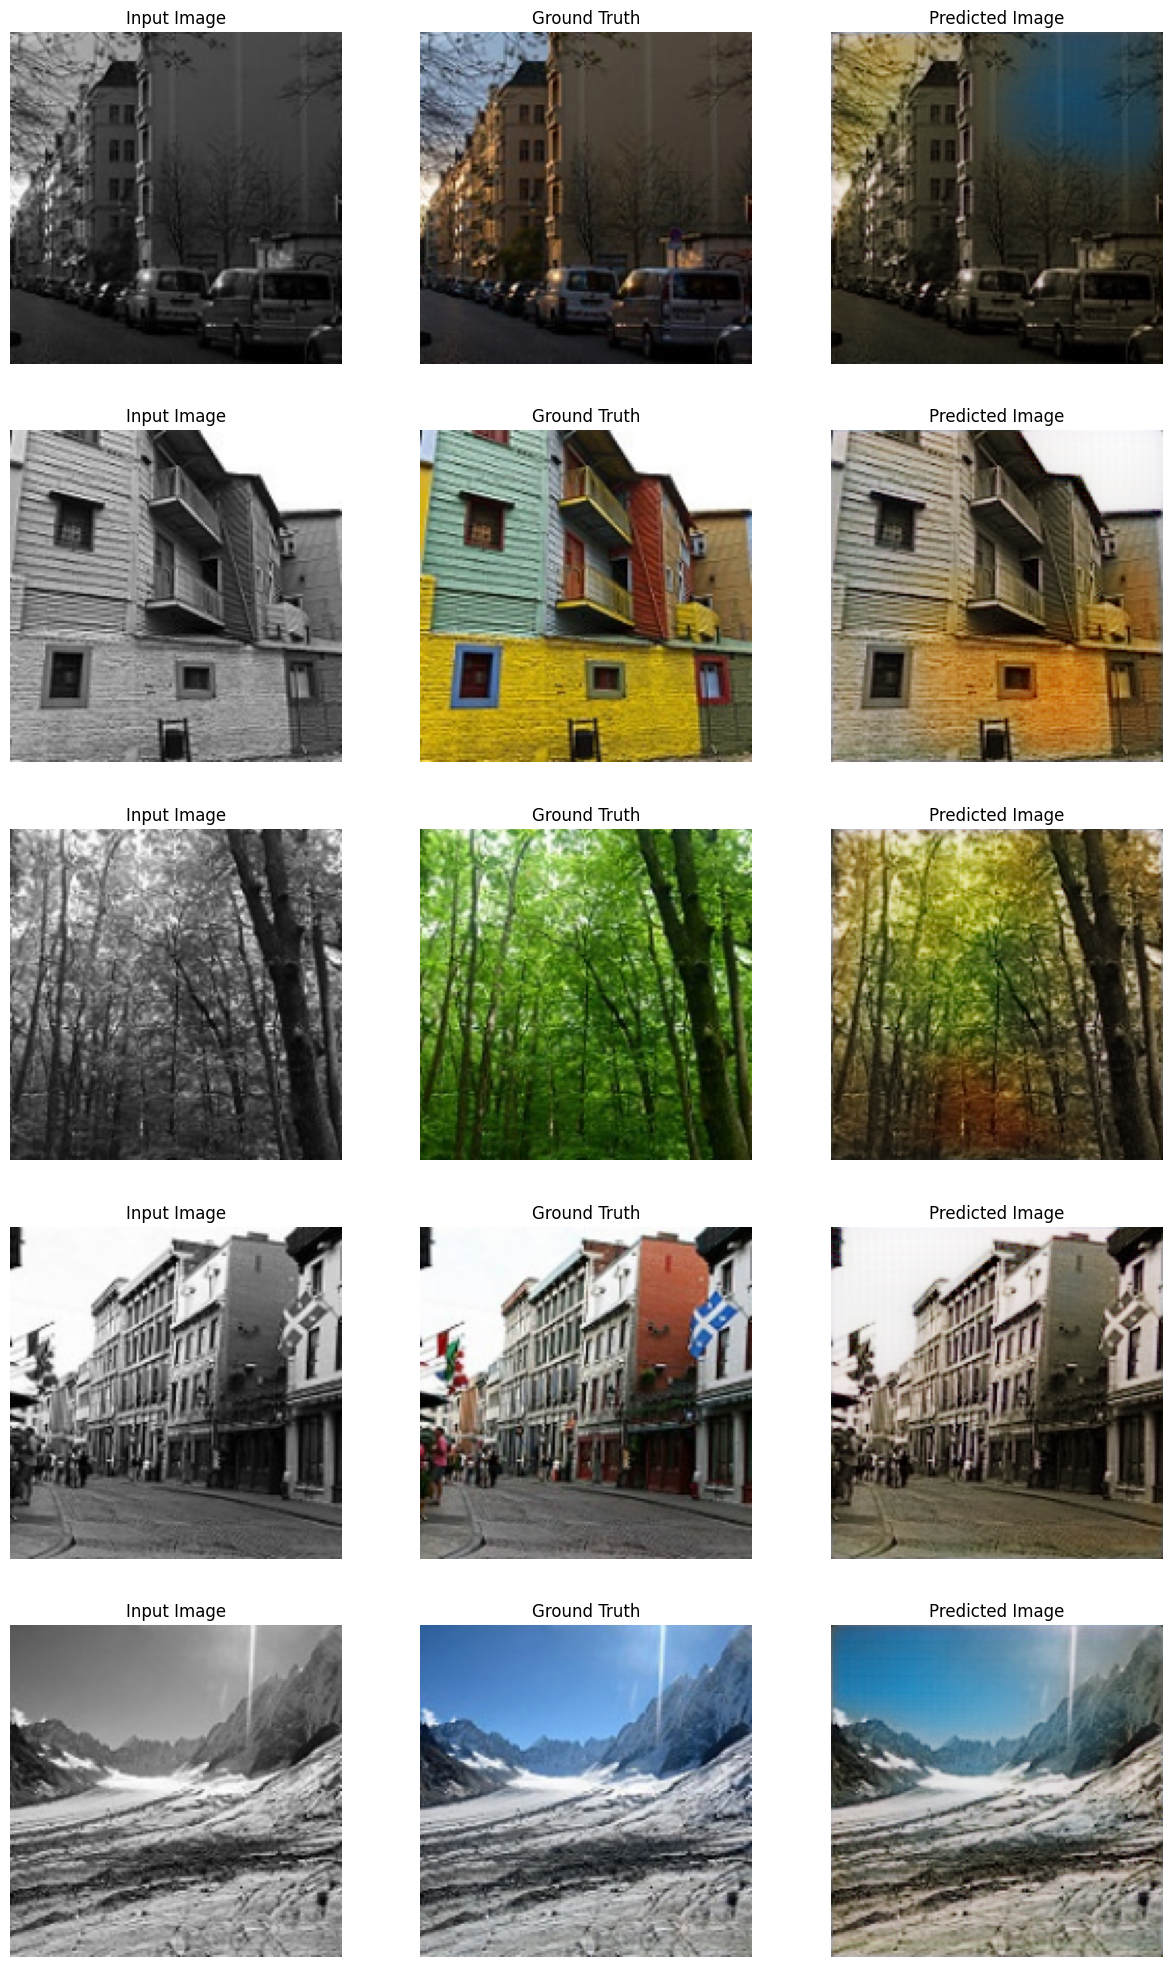

In [14]:
import matplotlib.pyplot as plt

def generate_images(model, test_input, tar, num_images=1):
    # Generate predictions for the input batch
    predictions = model(test_input, training=True)

    # Set up the plot size based on the number of images
    plt.figure(figsize=(15, 5 * num_images))

    for i in range(num_images):
        display_list = [test_input[i], tar[i], predictions[i]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']

        for j in range(3):
            plt.subplot(num_images, 3, i * 3 + j + 1)
            plt.title(title[j])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(display_list[j])
            plt.axis('off')

    plt.show()

# Example usage with the ImageDataGenerator
img_size = 160
batch_size = 64
epochs = 20

# Paths to your datasets
color_path = '..\kaggle\input\landscape-image-colorization\landscape_Images\color'
gray_path = '..\kaggle\input\landscape-image-colorization\landscape_Images\gray'

# Create an instance of the ImageDataGenerator
train_ds = ImageDataGenerator(color_path=color_path, gray_path=gray_path, batch_size=batch_size, img_size=img_size,limit = 1500)

color_img = []
gray_img = []

num_images_to_display = 5  # Set how many images you want to display
for batch in train_ds:
    example_input, example_target = batch
    color_img.append(example_target)
    gray_img.append(example_input)
    # Make sure you don't try to display more images than exist in the batch
    num_images_to_display = min(num_images_to_display, example_input.shape[0])

    generate_images(generator, example_input, example_target, num_images=num_images_to_display)
    break  # Only process the first batch for visualization purposes

